In [100]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [101]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *                       
from etl import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# df = readfilerun_simple('data/raw/train_r/20220116T055105_20-100-true-20-100-iperf.csv')
# df = genfeat(readfilerun_simple('data/raw/switch/20220119T055428_300-500-true-300-5000-iperf.csv', 'data/raw/switch'))
df = genfeat(readfilerun_simple('data/jennawk5data/20220201T010740_200-100-true-200-10000-200-iperf.csv', 'data/jennawk5data'))

df10 = agg10(df)
dfagg = better_agg(df)
dfagg.head()

,total_bytes,max_bytes,max_bytes_std,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,total_pkts_amin,...,mean_tdelta,mean_tdelta_amin,mean_tdelta_amax,max_tdelta,max_tdelta_amin,max_tdelta_amax,latency,loss,later_latency,later_loss
0,42773.333333,11406.222222,3019.749070,6,41851.555556,921.777778,28.111111,16.888889,45.000000,12,...,13.950336,0.000000,24.342857,323.777778,0,402,200,100,200,10000
1,83763.555556,8697.777778,2237.607750,6,82000.000000,1763.555556,54.666667,33.222222,87.888889,47,...,11.851818,7.177778,19.326087,129.444444,84,202,200,100,200,10000
2,57100.400000,6267.600000,2296.259722,6,55950.000000,1150.400000,37.300000,20.600000,57.900000,28,...,18.885397,10.931034,30.571429,136.500000,65,350,200,100,200,10000
3,59433.777778,12845.777778,9701.063470,6,58500.000000,933.777778,39.000000,17.444444,56.444444,24,...,20.563285,9.571429,38.260870,223.666667,194,289,200,100,200,10000
4,49528.400000,7309.200000,2242.456629,6,48600.000000,928.400000,32.400000,16.600000,49.000000,31,...,18.022326,10.288462,24.342857,223.200000,177,272,200,100,200,10000


In [103]:
df['event'].unique()

array(['drop', nan, 'drop;drop', 'drop;drop;drop'], dtype=object)

In [104]:
ct = pd.read_csv('outputs/combined_transform.csv').rename(
    {'mean_tdelta.1': 'mean_tdelta_amin', 'mean_tdelta.2':'mean_tdelta_amax'}, 
    axis=1)
ct.head()

,total_bytes,max_bytes,max_bytes_std,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,total_pkts_amin,...,mean_tdelta,mean_tdelta_amin,mean_tdelta_amax,max_tdelta,max_tdelta_amin,max_tdelta_amax,latency,loss,later_latency,later_loss
0,1254903.6,16261.6,4620.980252,6,1231800.0,23103.6,821.2,437.1,1258.3,784,...,0.764622,0.431958,1.233716,85.7,34,168,20,2000,20,2000
1,1725598.8,18534.0,9597.535841,6,1697400.0,28198.8,1131.6,539.7,1671.3,1440,...,0.599958,0.473884,0.694232,26.6,9,58,20,2000,20,2000
2,2036649.6,15224.8,2460.232184,6,2003550.0,33099.6,1335.7,633.0,1968.7,1695,...,0.511561,0.438133,0.586777,17.5,9,29,20,2000,20,2000
3,1773897.6,12337.2,1822.065299,6,1744500.0,29397.6,1163.0,561.6,1724.6,1512,...,0.580953,0.511329,0.660490,12.5,8,19,20,2000,20,2000
4,1809538.4,14474.4,2964.950335,6,1780200.0,29338.4,1186.8,561.2,1748.0,1485,...,0.575136,0.476533,0.673181,11.6,9,14,20,2000,20,2000


In [105]:
ct.columns

Index(['total_bytes', 'max_bytes', 'max_bytes_std', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'total_pkts', 'total_pkts_amin',
       'total_pkts_amax', 'number_ms', 'pkt_ratio', 'time_spread',
       'time_spread_amin', 'time_spread_amax', 'pkt sum', 'longest_seq',
       'longest_seq_amin', 'longest_seq_amax', 'total_pkt_sizes', 'byte_ratio',
       'mean_tdelta', 'mean_tdelta_amin', 'mean_tdelta_amax', 'max_tdelta',
       'max_tdelta_amin', 'max_tdelta_amax', 'latency', 'loss',
       'later_latency', 'later_loss'],
      dtype='object')

In [106]:
label_col = 'loss'
# indexcol = ['total_bytes', 'max_bytes', '2->1Bytes', '2->1Pkts', 'total_pkts',
#        'number_ms', 'pkt_ratio', 'time_spread', 'pkt sum', 'longest_seq',
#        'total_pkt_sizes', 'byte_ratio', 'mean_tdelta', 'max_tdelta']
# indexcol = ['total_bytes', 'max_bytes', 'max_bytes_std',
#        '2->1Bytes', '2->1Pkts', 'total_pkts', 'total_pkts_amin',
#        'total_pkts_amax', 'number_ms', 'pkt_ratio', 'time_spread',
#        'time_spread_amin', 'time_spread_amax', 'pkt sum', 'longest_seq',
#        'longest_seq_amin', 'longest_seq_amax', 'total_pkt_sizes', 'byte_ratio',
#        'mean_tdelta', 'mean_tdelta_amin', 'mean_tdelta_amax', 'max_tdelta',
#        'max_tdelta_amin', 'max_tdelta_amax']
# latency features
indexcol = ['byte_ratio', 'pkt_ratio', 'time_spread', 'total_bytes', '2->1Pkts']
# loss features
indexcol = ['total_pkts', 'total_pkt_sizes', '2->1Bytes', 'number_ms', 'mean_tdelta', 'max_tdelta'] 
    
# print(len(indexcol),df[[x for x in indexcol if x in df.columns]])

X_train, X_test, y_train, y_test = train_test_split(
    ct[[x for x in indexcol if x in df.columns]], ct[label_col])
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
etree = RandomForestRegressor(n_estimators=400, n_jobs=4)
etreeft = etree.fit(X_train,y_train)

y_pred3 = etree.predict(X_test)
acc3= mean_squared_error(y_test, y_pred3)

print(f'mse: {acc3}, r2: {etree.score(X_test, y_test)}')
feat_imp = pd.Series(index=[x for x in indexcol if x in df.columns], 
          data=etree.feature_importances_).sort_values(ascending=False)
feat_imp

mse: 15249923.041988233, r2: 0.6438658360280634


2->1Bytes          0.576947
max_tdelta         0.136881
mean_tdelta        0.084392
number_ms          0.076637
total_pkt_sizes    0.063849
total_pkts         0.061294
dtype: float64

In [107]:
ct['total_pkts_amax']

0       1688
1       2107
2       2272
3       1943
4       2089
        ... 
7898    1533
7899    1452
7900    2187
7901    1871
7902    1354
Name: total_pkts_amax, Length: 7903, dtype: int64

In [108]:
dfr.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'total_bytes', 'total_pkts', 'pkt sum',
       'longest_seq', 'mean_tdelta', 'max_tdelta', 'number_ms', 'max_bytes',
       'total_pkt_sizes', 'pkt_ratio', 'time_spread', 'byte_ratio',
       'prediction'],
      dtype='object')

In [109]:
ct[['total_pkts_amax', 'total_pkts']].corr()

,total_pkts_amax,total_pkts
total_pkts_amax,1.000000,0.941817
total_pkts,0.941817,1.000000


In [110]:
dfr = df.reset_index(drop=True)
dfr

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,13724,11,0.000000,0,1,13724,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,52520,3,13.694915,402,8,12284,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,43456,2,7.400000,399,9,10916,43456,776.000000,407,776.000000
3,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,64196,3,12.656250,400,11,9156,64196,987.630769,810,987.630769
4,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42728,2,9.878049,399,7,15260,42728,1017.333333,405,1017.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1831732,10,0.583234,33,243,27312,1831732,1096.189108,974,1096.189108
298,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1598288,7,0.675970,36,199,27312,1598288,1087.270748,993,1087.270748
299,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,2189224,8,0.493253,34,223,27364,2189224,1093.518482,987,1093.518482
300,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1907884,8,0.554802,35,210,27416,1907884,1077.291925,982,1077.291925


In [111]:
dfp = dfr
dfr['prediction'] = etree.predict(dfr[indexcol].rolling(10).mean().bfill()) # prediction

dfr

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,11,0.000000,0,1,13724,13724,1143.666667,0,1143.666667,105.25
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,3,13.694915,402,8,12284,52520,875.333333,808,875.333333,105.25
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,2,7.400000,399,9,10916,43456,776.000000,407,776.000000,105.25
3,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,3,12.656250,400,11,9156,64196,987.630769,810,987.630769,105.25
4,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,2,9.878049,399,7,15260,42728,1017.333333,405,1017.333333,105.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,10,0.583234,33,243,27312,1831732,1096.189108,974,1096.189108,9795.00
298,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,7,0.675970,36,199,27312,1598288,1087.270748,993,1087.270748,9170.00
299,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,8,0.493253,34,223,27364,2189224,1093.518482,987,1093.518482,8717.50
300,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,8,0.554802,35,210,27416,1907884,1077.291925,982,1077.291925,11225.00


<AxesSubplot:>

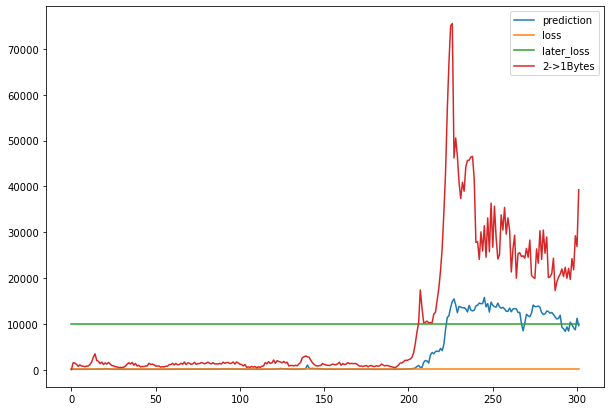

In [112]:
dfr[['prediction', 'loss', 'later_loss', '2->1Bytes']].plot(figsize=(10,7))

In [118]:
filename='data/jennawk5data/20220201T010740_200-100-true-200-10000-200-iperf.csv'
losslog_dir = 'data/jennawk5data'
run_labels = filename.split('_')[-1].split('-')[:-1]
temp_label_str = '-'.join(run_labels) 
losslog = f'{losslog_dir}/losslog-{temp_label_str}.csv' #losslog filename str

run_df = pd.read_csv(filename)
losslog_df = pd.read_csv(losslog, header=None).rename(
    columns={0:'event', 1:'drop_unix', 2:'IP1', 3:'Port1', 4:'IP2', 5:'Port2', 6:'Proto'})
losslog_df['Time'] = losslog_df['drop_unix'].astype(int)
# losslog_df = losslog_df.groupby(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto']).agg(
#     lambda x: ';'.join(x.astype(str))).reset_index() # TODO find a way to handle this see: event and drop_unix columns should be semicolon separable values in string format.
# losslog_df['event'].unique()
losslog_df[losslog_df['event'] == 'switch']

,event,drop_unix,IP1,Port1,IP2,Port2,Proto,Time
136,switch,1.643678e+09,NaN,NaN,NaN,NaN,NaN,1643677855


In [119]:
run_df[run_df['Time'] == 1643677855]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
200,1643677855,192.168.96.3,47330,192.168.48.2,5001,6,97500,1460,65,26,1643677855044;1643677855044;1643677855044;1643...,52;1500;1500;52;1500;1500;52;1500;1500;1500;15...,2;1;1;2;1;1;2;1;1;1;1;1;1;2;1;1;2;1;1;2;1;1;1;...
